In [6]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer


In [7]:
!pip install faiss-cpu



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 45.9 MB/s eta 0:00:00


In [8]:
import faiss


final version


In [9]:
import ast
import re

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load E5-large model
# model = SentenceTransformer('intfloat/e5-large')
# model = SentenceTransformer("moka-ai/m3e-base")
model = SentenceTransformer("all-mpnet-base-v2")

# model = SentenceTransformer("BAAI/bge-base-en-v1.5")
model = model.to(device)

# -----------------------------
# LOAD PRODUCT CATALOG
# -----------------------------
catalog_df = pd.read_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Zepto Data Challenge_ Intent prediction - catalog.csv")
catalog_df = catalog_df.drop_duplicates(subset=["product_variant_id"])

# -----------------------------
# LOAD LABELED SEARCH DATASET
# -----------------------------
labeled_df = pd.read_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Zepto Data Challenge_ Intent prediction - labelled_data.csv")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def parse_list_string(text):
    if pd.isna(text) or text == '':
        return []
    try:
        # Handle cases where the list is represented as a string
        return ast.literal_eval(text)
    except (ValueError, SyntaxError):
        # Try to extract strings between quotes using regex
        matches = re.findall(r'"([^"]*)"', text)
        if matches:
            return matches
        return []

In [ ]:
labeled_df['l1_preds'] = labeled_df['l1_preds'].apply(parse_list_string)
labeled_df['l2_preds'] = labeled_df['l2_preds'].apply(parse_list_string)
labeled_df['l3_preds'] = labeled_df['l3_preds'].apply(parse_list_string)

In [ ]:
# -----------------------------
# PROCESS L1 CATEGORIES
# -----------------------------
print("Processing L1 categories...")

# Extract all unique L1 categories from catalog
catalog_l1_df = catalog_df[['product_variant_id', 'product_name', 'l1_name']].copy()
catalog_l1_df.rename(columns={'l1_name': 'category'}, inplace=True)
catalog_l1_df['source'] = 'catalog'
catalog_l1_df['level'] = 'L1'

# Extract all L1 categories from labeled data
labeled_l1_rows = []
for idx, row in labeled_df.iterrows():
    search_term = row['search_term']
    for l1 in row['l1_preds']:
        labeled_l1_rows.append({
            'product_name': search_term,
            'category': l1,
            'source': 'labeled',
            'level': 'L1'
        })

labeled_l1_df = pd.DataFrame(labeled_l1_rows)

# Combine catalog and labeled L1 data
all_l1_df = pd.concat([
    catalog_l1_df[['product_name', 'category', 'source', 'level']],
    labeled_l1_df[['product_name', 'category', 'source', 'level']]
])

# Generate L1 embeddings
def format_l1_text(row):
    return f"passage: {row['product_name']} | {row['category']} "

all_l1_texts = all_l1_df.apply(format_l1_text, axis=1).tolist()
all_l1_embeddings = model.encode(
    all_l1_texts,
    batch_size=64,
    convert_to_tensor=False,
    normalize_embeddings=True,
    show_progress_bar=True
)

Processing L1 categories...


Batches:   0%|          | 0/488 [00:00<?, ?it/s]

In [ ]:
# -----------------------------
# PROCESS L2 CATEGORIES
# -----------------------------
print("Processing L2 categories...")

# Extract all unique L2 categories from catalog
catalog_l2_df = catalog_df[['product_variant_id', 'product_name', 'l2_name']].copy()
catalog_l2_df.rename(columns={'l2_name': 'category'}, inplace=True)
catalog_l2_df['source'] = 'catalog'
catalog_l2_df['level'] = 'L2'

# Extract all L2 categories from labeled data
labeled_l2_rows = []
for idx, row in labeled_df.iterrows():
    search_term = row['search_term']
    for l2 in row['l2_preds']:
        labeled_l2_rows.append({
            'product_name': search_term,
            'category': l2,
            'source': 'labeled',
            'level': 'L2'
        })

labeled_l2_df = pd.DataFrame(labeled_l2_rows)

# Combine catalog and labeled L2 data
all_l2_df = pd.concat([
    catalog_l2_df[['product_name', 'category', 'source', 'level']],
    labeled_l2_df[['product_name', 'category', 'source', 'level']]
])

# Generate L2 embeddings
def format_l2_text(row):
    return f"passage: {row['product_name']} | {row['category']}"

all_l2_texts = all_l2_df.apply(format_l2_text, axis=1).tolist()
all_l2_embeddings = model.encode(
    all_l2_texts,
    batch_size=64,
    convert_to_tensor=False,
    normalize_embeddings=True,
    show_progress_bar=True
)

Processing L2 categories...


Batches:   0%|          | 0/534 [00:00<?, ?it/s]

In [ ]:
# -----------------------------
# PROCESS L3 CATEGORIES
# -----------------------------
print("Processing L3 categories...")

# Extract all unique L3 categories from catalog
catalog_l3_df = catalog_df[['product_variant_id', 'product_name', 'l3_name']].copy()
catalog_l3_df.rename(columns={'l3_name': 'category'}, inplace=True)
catalog_l3_df['source'] = 'catalog'
catalog_l3_df['level'] = 'L3'

# Extract all L3 categories from labeled data
labeled_l3_rows = []
for idx, row in labeled_df.iterrows():
    search_term = row['search_term']
    for l3 in row['l3_preds']:
        labeled_l3_rows.append({
            'product_name': search_term,
            'category': l3,
            'source': 'labeled',
            'level': 'L3'
        })

labeled_l3_df = pd.DataFrame(labeled_l3_rows)

# Combine catalog and labeled L3 data
all_l3_df = pd.concat([
    catalog_l3_df[['product_name', 'category', 'source', 'level']],
    labeled_l3_df[['product_name', 'category', 'source', 'level']]
])

# Generate L3 embeddings
def format_l3_text(row):
    return f"passage: {row['product_name']} | {row['category']}"

all_l3_texts = all_l3_df.apply(format_l3_text, axis=1).tolist()
all_l3_embeddings = model.encode(
    all_l3_texts,
    batch_size=64,
    convert_to_tensor=False,
    normalize_embeddings=True,
    show_progress_bar=True
)

Processing L3 categories...


Batches:   0%|          | 0/654 [00:00<?, ?it/s]

In [1]:
# -----------------------------
# SAVE ALL DATA AND EMBEDDINGS
# -----------------------------
# Save the dataframes
all_l1_df.to_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l1_data.csv", index=False)
all_l2_df.to_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l2_data.csv", index=False)
all_l3_df.to_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l3_data.csv", index=False)

# Save the embeddings
np.save("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l1_embeddings.npy", all_l1_embeddings)
np.save("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l2_embeddings.npy", all_l2_embeddings)
np.save("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l3_embeddings.npy", all_l3_embeddings)

print(f"Saved embeddings: L1={len(all_l1_embeddings)}, L2={len(all_l2_embeddings)}, L3={len(all_l3_embeddings)}")
print("Complete!")

NameError: name 'all_l1_df' is not defined

In [2]:
def load_model_and_data():
    """Load the model and all necessary data"""
    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # model = SentenceTransformer('intfloat/e5-large')
    # model = SentenceTransformer('moka-ai/m3e-base')
    model = SentenceTransformer("all-mpnet-base-v2")

    # model = SentenceTransformer("BAAI/bge-base-en-v1.5")


    model = model.to(device)

    # Load embeddings and metadata for each level
    l1_embeddings = np.load("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l1_embeddings.npy")
    l2_embeddings = np.load("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l2_embeddings.npy")
    l3_embeddings = np.load("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l3_embeddings.npy")

    l1_df = pd.read_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l1_data.csv")
    l2_df = pd.read_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l2_data.csv")
    l3_df = pd.read_csv("/content/drive/MyDrive/Zepto IDC Query Classification/Generated Files/all_l3_data.csv")

    # Create FAISS indices for fast searching
    dimension = l1_embeddings.shape[1]

    # L1 index
    l1_index = faiss.IndexFlatIP(dimension)  # Inner product search for cosine similarity with normalized vectors
    l1_index.add(l1_embeddings)

    # L2 index
    l2_index = faiss.IndexFlatIP(dimension)
    l2_index.add(l2_embeddings)

    # L3 index
    l3_index = faiss.IndexFlatIP(dimension)
    l3_index.add(l3_embeddings)

    return model, (l1_index, l2_index, l3_index), (l1_df, l2_df, l3_df)

In [3]:
def search(query, k=10, model=None, indices=None, dataframes=None, threshold=0.5):
    """
    Search for top k matching categories at each level (L1, L2, L3)

    Args:
        query: Search query string
        k: Number of top results to return per level
        model: Pre-loaded SentenceTransformer model
        indices: Tuple of (l1_index, l2_index, l3_index)
        dataframes: Tuple of (l1_df, l2_df, l3_df)
        threshold: Minimum similarity score to include in results

    Returns:
        Dictionary with top matches for each level
    """
    # Load model and data if not provided
    if model is None or indices is None or dataframes is None:
        model, indices, dataframes = load_model_and_data()

    l1_index, l2_index, l3_index = indices
    l1_df, l2_df, l3_df = dataframes

    # Encode the search query for each level
    l1_query_text = f"passage: {query}"
    l2_query_text = f"passage: {query}"
    l3_query_text = f"passage: {query}"

    l1_query_embedding = model.encode([l1_query_text], normalize_embeddings=True)
    l2_query_embedding = model.encode([l2_query_text], normalize_embeddings=True)
    l3_query_embedding = model.encode([l3_query_text], normalize_embeddings=True)

    # Search each level
    l1_scores, l1_indices = l1_index.search(l1_query_embedding, k)
    l2_scores, l2_indices = l2_index.search(l2_query_embedding, k)
    l3_scores, l3_indices = l3_index.search(l3_query_embedding, k)

    # Process L1 results
    l1_results = []
    for i, (score, idx) in enumerate(zip(l1_scores[0], l1_indices[0])):
        if score < threshold:
            continue
        row = l1_df.iloc[idx]
        l1_results.append({
            'level': 'L1',
            'category': row['category'],
            'product_name': row['product_name'],
            'source': row['source'],
            'score': float(score)
        })

    # Process L2 results
    l2_results = []
    for i, (score, idx) in enumerate(zip(l2_scores[0], l2_indices[0])):
        if score < threshold:
            continue
        row = l2_df.iloc[idx]
        l2_results.append({
            'level': 'L2',
            'category': row['category'],
            'product_name': row['product_name'],
            'source': row['source'],
            'score': float(score)
        })

    # Process L3 results
    l3_results = []
    for i, (score, idx) in enumerate(zip(l3_scores[0], l3_indices[0])):
        if score < threshold:
            continue
        row = l3_df.iloc[idx]
        l3_results.append({
            'level': 'L3',
            'category': row['category'],
            'product_name': row['product_name'],
            'source': row['source'],
            'score': float(score)
        })

    return {
        'L1': l1_results,
        'L2': l2_results,
        'L3': l3_results
    }

In [4]:
def search_and_format(query, k=10):
    """
    Search and format results in a nice way
    """
    model, indices, dataframes = load_model_and_data()
    all_results = search(query, k=k, model=model, indices=indices, dataframes=dataframes)

    # Format results
    formatted_results = []

    # Process L1, L2, L3 matches
    for level, results in all_results.items():
        for res in results:
            formatted_results.append({
                'score': res['score'],
                'level': level,
                'category': res['category'],
                'product_name': res['product_name'],
                'source': res['source']
            })

    # Sort by score
    formatted_results.sort(key=lambda x: x['score'], reverse=True)

    return formatted_results

In [10]:
if __name__ == "__main__":
    # Load once for efficiency
    model, indices, dataframes = load_model_and_data()

    # Search for a query
    query = "epigamia yogurt"
    results = search(query, k=10, model=model, indices=indices, dataframes=dataframes)

    print(f"Top results for: '{query}'")
    print("\nL1 Categories:")
    for res in results['L1']:
        print(f"[{res['score']:.4f}] {res['category']} ({res['product_name']})")

    print("\nL2 Categories:")
    for res in results['L2']:
        print(f"[{res['score']:.4f}] {res['category']} ({res['product_name']})")

    print("\nL3 Categories:")
    for res in results['L3']:
        print(f"[{res['score']:.4f}] {res['category']} ({res['product_name']})")

    # # Alternative usage with simplified output
    # print("\nAll results sorted by relevance:")
    # formatted = search_and_format(query, k=10)
    # for res in formatted[:15]:  # Show top 15 overall results
    #     print(f"[{res['score']:.4f}] {res['product_name']} → {res['level']}: {res['category']} ({res['source']})")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Top results for: 'epigamia yogurt'

L1 Categories:
[0.8739] Dairy, Bread & Eggs (epigamia yogurt)
[0.8453] Cold Drinks & Juices (epigamia yogurt)
[0.8010] Dairy, Bread & Eggs (epigamia greek yogurt- natural)
[0.8010] Dairy, Bread & Eggs (epigamia greek yogurt- natural)
[0.8006] Dairy, Bread & Eggs (epigamia greek yogurt- vanilla bean)
[0.7983] Dairy, Bread & Eggs (epigamia fruit yogurt- strawberry)
[0.7913] Dairy, Bread & Eggs (epigamia greek yogurt- raspberry)
[0.7890] Dairy, Bread & Eggs (epigamia strawberry flavoured yogurt)
[0.7889] Dairy, Bread & Eggs (epigamia lychee flavoured yogurt)
[0.7870] Dairy, Bread & Eggs (epigamia turbo yoghurt)

L2 Categories:
[0.9216] Milk Drinks (epigamia yogurt)
[0.9024] Yogurts & Dahi (epigamia yogurt)
[0.8794] Yogurts & Dahi (epigamia g)
[0.8428] Yogurts & Dahi (epigamia greek yogurt- natural)
[0.8428] Yogurts & Dahi (epigamia greek yogurt- natural)
[0.8290] Yogurts & Dahi (epigamia fruit yogurt- strawberry)
[0.8265] Yogurts & Dahi (epigamia greek 

In [12]:
if __name__ == "__main__":
    # Load once for efficiency
    model, indices, dataframes = load_model_and_data()

    # Search for a query
    query = "sri sri ghee"
    results = search(query, k=10, model=model, indices=indices, dataframes=dataframes)

    print(f"Top results for: '{query}'")
    print("\nL1 Categories:")
    for res in results['L1']:
        print(f"[{res['score']:.4f}] {res['category']} ({res['product_name']})")

    print("\nL2 Categories:")
    for res in results['L2']:
        print(f"[{res['score']:.4f}] {res['category']} ({res['product_name']})")

    print("\nL3 Categories:")
    for res in results['L3']:
        print(f"[{res['score']:.4f}] {res['category']} ({res['product_name']})")

Top results for: 'sri sri ghee'

L1 Categories:
[0.6275] Munchies (sriram bhujia)
[0.5772] Munchies (besan ghatiya)
[0.5762] Sweet Cravings (ghee karam)
[0.5740] Stationery & Books (shrimad bhagwat geeta yatharoop (hindi))
[0.5713] Sweet Cravings (ghar ka saman)
[0.5705] Munchies (gwalia bhujia)
[0.5701] Atta, Rice, Oil & Dals (ghee brush)
[0.5690] Munchies (gopal namkeen gathiya)
[0.5673] Home Needs (ghee karam)
[0.5671] Atta, Rice, Oil & Dals (himalaya cow ghee)

L2 Categories:
[0.7352] Ghee (patanjali s)
[0.7050] Ghee (amul desi g)
[0.7045] Ghee (aashirvaad)
[0.7006] Ghee (ghee karam)
[0.6979] South Indian (ghee karam)
[0.6859] Ghee (govardhan ki)
[0.6802] Namkeens (sriram bhujia)
[0.6773] Indian Mithai (ghee karam)
[0.6741] Ghee (akshayakalpa chee)
[0.6704] Ghee (amul malai p)

L3 Categories:
[0.7007] Pooja Ghee (ghee karam)
[0.6780] A2 Ghee (ghee karam)
[0.6770] Holy Book (shrimad bhagwat geeta yatharoop (hindi))
[0.6707] Mysore Pak (ghee karam)
[0.6466] Gathiya (besan ghatiya)
[0

# **THRESHOLDING**

In [ ]:
def evaluate_thresholds(labeled_df, model, indices, dataframes, thresholds=np.arange(0.1, 1.0, 0.05), k=10):
    level_scores = {'L1': [], 'L2': [], 'L3': []}

    for threshold in thresholds:
        correct = {'L1': 0, 'L2': 0, 'L3': 0}
        total = len(labeled_df)

        for _, row in tqdm(labeled_df.iterrows(), total=len(labeled_df), desc=f"Threshold {threshold:.2f}"):
            query = row["search_term"]
            true_l1 = set(row["l1_preds"])
            true_l2 = set(row["l2_preds"])
            true_l3 = set(row["l3_preds"])

            results = search(query, k=k, model=model, indices=indices, dataframes=dataframes, threshold=threshold)

            pred_l1 = set([r["category"] for r in results["L1"]])
            pred_l2 = set([r["category"] for r in results["L2"]])
            pred_l3 = set([r["category"] for r in results["L3"]])

            if pred_l1 & true_l1:
                correct["L1"] += 1
            if pred_l2 & true_l2:
                correct["L2"] += 1
            if pred_l3 & true_l3:
                correct["L3"] += 1

        # Compute accuracy at each level
        level_scores["L1"].append((threshold, correct["L1"] / total))
        level_scores["L2"].append((threshold, correct["L2"] / total))
        level_scores["L3"].append((threshold, correct["L3"] / total))

    return level_scores


In [ ]:
import matplotlib.pyplot as plt

def plot_threshold_accuracy(level_scores):
    for level in ["L1", "L2", "L3"]:
        thresholds, accuracies = zip(*level_scores[level])
        plt.plot(thresholds, accuracies, label=f"{level} Accuracy")

    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

def best_thresholds(level_scores):
    return {level: max(scores, key=lambda x: x[1]) for level, scores in level_scores.items()}


Threshold 0.90: 100%|██████████| 100/100 [00:07<00:00, 14.26it/s]


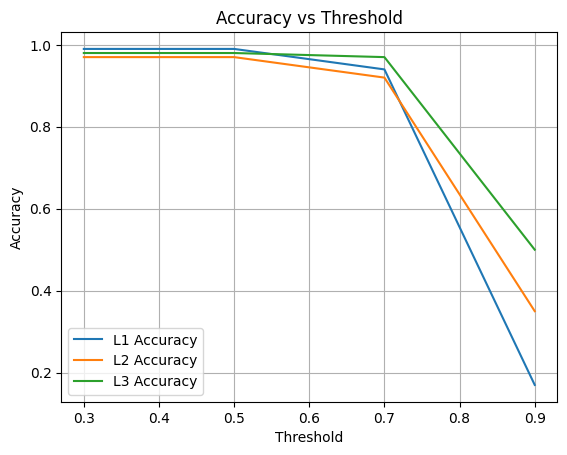

Best thresholds per level:
{'L1': (np.float64(0.3), 0.99), 'L2': (np.float64(0.3), 0.97), 'L3': (np.float64(0.3), 0.98)}


In [ ]:
labeled_sample = labeled_df.sample(n=100, random_state=42).reset_index(drop=True)

# Step 2: Run threshold evaluation
model, indices, dataframes = load_model_and_data()

level_scores = evaluate_thresholds(
    labeled_sample,
    model=model,
    indices=indices,
    dataframes=dataframes,
    thresholds=np.arange(0.3, 0.95, 0.2),
    k=10
)

# Step 3: Plot accuracy vs threshold
plot_threshold_accuracy(level_scores)

# Step 4: Print best threshold per level
print("Best thresholds per level:")
print(best_thresholds(level_scores))


Threshold 0.98: 100%|██████████| 500/500 [00:36<00:00, 13.72it/s]


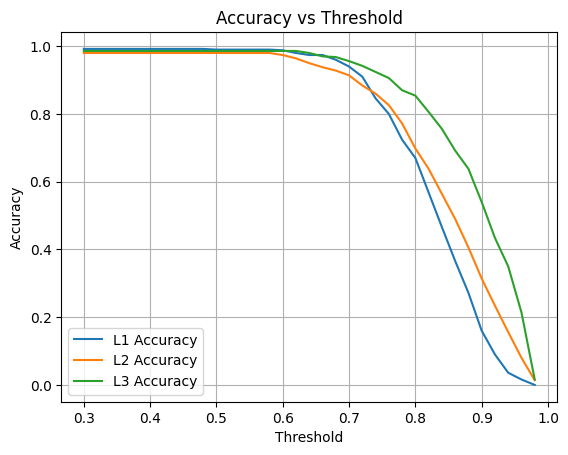

Best thresholds per level:
{'L1': (np.float64(0.3), 0.992), 'L2': (np.float64(0.3), 0.98), 'L3': (np.float64(0.3), 0.986)}


In [ ]:
labeled_sample = labeled_df.sample(n=500, random_state=42).reset_index(drop=True)

# Step 2: Run threshold evaluation
model, indices, dataframes = load_model_and_data()

level_scores = evaluate_thresholds(
    labeled_sample,
    model=model,
    indices=indices,
    dataframes=dataframes,
    thresholds=np.arange(0.3, 0.99, 0.02),
    k=10
)

# Step 3: Plot accuracy vs threshold
plot_threshold_accuracy(level_scores)

# Step 4: Print best threshold per level
print("Best thresholds per level:")
print(best_thresholds(level_scores))


In [ ]:
from sklearn.model_selection import train_test_split

# -----------------------------
# SPLIT LABELED DATASET
# -----------------------------
train_df, test_df = train_test_split(
    labeled_df,
    test_size=0.2,
    random_state=42,
    stratify=labeled_df["l1_preds"].apply(lambda x: x[0] if isinstance(x, list) and x else "Unknown")
)

# -----------------------------
# EXTRACT TRAIN EMBEDDINGS ONLY
# -----------------------------
def extract_level_rows(df, level):
    rows = []
    for _, row in df.iterrows():
        query = row['search_term']
        labels = row[f'{level.lower()}_preds']
        for label in labels:
            rows.append({
                'product_name': query,
                'category': label,
                'source': 'labeled',
                'level': level
            })
    return pd.DataFrame(rows)

labeled_l1_df = extract_level_rows(train_df, 'L1')
labeled_l2_df = extract_level_rows(train_df, 'L2')
labeled_l3_df = extract_level_rows(train_df, 'L3')

# Format for embedding
def format_text(row): return f"passage: {row['product_name']} | {row['category']}"

texts_l1 = labeled_l1_df.apply(format_text, axis=1).tolist()
texts_l2 = labeled_l2_df.apply(format_text, axis=1).tolist()
texts_l3 = labeled_l3_df.apply(format_text, axis=1).tolist()

emb_l1 = model.encode(texts_l1, batch_size=64, convert_to_tensor=False, normalize_embeddings=True, show_progress_bar=True)
emb_l2 = model.encode(texts_l2, batch_size=64, convert_to_tensor=False, normalize_embeddings=True, show_progress_bar=True)
emb_l3 = model.encode(texts_l3, batch_size=64, convert_to_tensor=False, normalize_embeddings=True, show_progress_bar=True)

# Build FAISS indices
dim = emb_l1.shape[1]
index_l1 = faiss.IndexFlatIP(dim); index_l1.add(np.array(emb_l1))
index_l2 = faiss.IndexFlatIP(dim); index_l2.add(np.array(emb_l2))
index_l3 = faiss.IndexFlatIP(dim); index_l3.add(np.array(emb_l3))


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

Batches:   0%|          | 0/317 [00:00<?, ?it/s]

Batches:   0%|          | 0/416 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_on_test(test_df, model, indices, dataframes, threshold=0.5, k=10):
    y_true_l1, y_pred_l1 = [], []
    y_true_l2, y_pred_l2 = [], []
    y_true_l3, y_pred_l3 = [], []

    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        query = row["search_term"]
        results = search(query, k=k, model=model, indices=indices, dataframes=dataframes, threshold=threshold)

        # Simplify: pick top result if available, else "None"
        pred_l1 = results["L1"][0]["category"] if results["L1"] else "None"
        pred_l2 = results["L2"][0]["category"] if results["L2"] else "None"
        pred_l3 = results["L3"][0]["category"] if results["L3"] else "None"

        y_pred_l1.append(pred_l1)
        y_pred_l2.append(pred_l2)
        y_pred_l3.append(pred_l3)

        y_true_l1.append(row["l1_preds"][0] if row["l1_preds"] else "None")
        y_true_l2.append(row["l2_preds"][0] if row["l2_preds"] else "None")
        y_true_l3.append(row["l3_preds"][0] if row["l3_preds"] else "None")

    print("L1 F1 Score:", f1_score(y_true_l1, y_pred_l1, average="weighted"))
    print("L2 F1 Score:", f1_score(y_true_l2, y_pred_l2, average="weighted"))
    print("L3 F1 Score:", f1_score(y_true_l3, y_pred_l3, average="weighted"))

    return y_true_l1, y_pred_l1, y_true_l2, y_pred_l2, y_true_l3, y_pred_l3


In [ ]:
evaluate_on_test(
    test_df,
    model=model,
    indices=(index_l1, index_l2, index_l3),
    dataframes=(labeled_l1_df, labeled_l2_df, labeled_l3_df),
    threshold=0.6,  # Or best threshold from earlier
    k=10
)

# level_scores = evaluate_thresholds(
#     test_df,
#     model=model,
#     indices=(index_l1, index_l2, index_l3),
#     dataframes=(labeled_l1_df, labeled_l2_df, labeled_l3_df),
#     thresholds=np.arange(0.3, 0.99, 0.02),
#     k=10
# )



100%|██████████| 2167/2167 [02:13<00:00, 16.27it/s]


L1 F1 Score: 0.4151353717525809
L2 F1 Score: 0.3875872628094351
L3 F1 Score: 0.36564195553761486


(['Biscuits',
  'Cleaning Essentials',
  'Home Needs',
  'Munchies',
  'Fruits & Vegetables',
  'Cold Drinks & Juices',
  'Packaged Food',
  'Dairy, Bread & Eggs',
  'Fruits & Vegetables',
  'Skincare',
  'Packaged Food',
  'Cold Drinks & Juices',
  'Biscuits',
  'Dairy, Bread & Eggs',
  'Biscuits',
  'Toys & Sports',
  'Bath & Body',
  'Toys & Sports',
  'Frozen Food',
  'Packaged Food',
  'Biscuits',
  'Fruits & Vegetables',
  'Home Needs',
  'Fruits & Vegetables',
  'Zepto Cafe',
  'Zepto Cafe',
  'Pharma & Wellness',
  'Baby Care',
  'Fruits & Vegetables',
  'Baby Care',
  'Home Needs',
  'Cleaning Essentials',
  'Zepto Cafe',
  'Stationery & Books',
  'Fragrances & Grooming',
  'Zepto Cafe',
  'Bath & Body',
  'Meats, Fish & Eggs',
  'Home Needs',
  'Zepto Cafe',
  'Masala, Dry Fruits & More',
  'Kitchen & Dining',
  'Atta, Rice, Oil & Dals',
  'Atta, Rice, Oil & Dals',
  'Dairy, Bread & Eggs',
  'Pharma & Wellness',
  'Kitchen & Dining',
  'Dairy, Bread & Eggs',
  'Frozen Food',


Threshold 0.90: 100%|██████████| 2167/2167 [02:13<00:00, 16.29it/s]


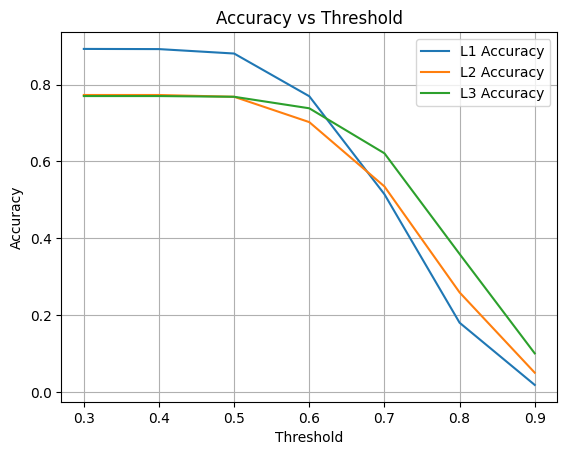

Best thresholds per level:
{'L1': (np.float64(0.3), 0.8929395477618828), 'L2': (np.float64(0.3), 0.7729580064605446), 'L3': (np.float64(0.3), 0.7701892016612829)}


In [ ]:
level_scores = evaluate_thresholds(
    test_df,
    model=model,
    indices=(index_l1, index_l2, index_l3),
    dataframes=(labeled_l1_df, labeled_l2_df, labeled_l3_df),
    thresholds=np.arange(0.3, 0.99, 0.1),
    k=10
)

plot_threshold_accuracy(level_scores)

print("Best thresholds per level:")
print(best_thresholds(level_scores))

In [ ]:
evaluate_on_test(
    test_df,
    model=model,
    indices=(index_l1, index_l2, index_l3),
    dataframes=(labeled_l1_df, labeled_l2_df, labeled_l3_df),
    threshold=0.3,  # Or best threshold from earlier
    k=10
)

100%|██████████| 2167/2167 [02:14<00:00, 16.08it/s]


L1 F1 Score: 0.4194815945377678
L2 F1 Score: 0.38971505480646973
L3 F1 Score: 0.3645919951431647


(['Biscuits',
  'Cleaning Essentials',
  'Home Needs',
  'Munchies',
  'Fruits & Vegetables',
  'Cold Drinks & Juices',
  'Packaged Food',
  'Dairy, Bread & Eggs',
  'Fruits & Vegetables',
  'Skincare',
  'Packaged Food',
  'Cold Drinks & Juices',
  'Biscuits',
  'Dairy, Bread & Eggs',
  'Biscuits',
  'Toys & Sports',
  'Bath & Body',
  'Toys & Sports',
  'Frozen Food',
  'Packaged Food',
  'Biscuits',
  'Fruits & Vegetables',
  'Home Needs',
  'Fruits & Vegetables',
  'Zepto Cafe',
  'Zepto Cafe',
  'Pharma & Wellness',
  'Baby Care',
  'Fruits & Vegetables',
  'Baby Care',
  'Home Needs',
  'Cleaning Essentials',
  'Zepto Cafe',
  'Stationery & Books',
  'Fragrances & Grooming',
  'Zepto Cafe',
  'Bath & Body',
  'Meats, Fish & Eggs',
  'Home Needs',
  'Zepto Cafe',
  'Masala, Dry Fruits & More',
  'Kitchen & Dining',
  'Atta, Rice, Oil & Dals',
  'Atta, Rice, Oil & Dals',
  'Dairy, Bread & Eggs',
  'Pharma & Wellness',
  'Kitchen & Dining',
  'Dairy, Bread & Eggs',
  'Frozen Food',


In [ ]:
evaluate_on_test(
    test_df,
    model=model,
    indices=(index_l1, index_l2, index_l3),
    dataframes=(labeled_l1_df, labeled_l2_df, labeled_l3_df),
    threshold=0.5,  # Or best threshold from earlier
    k=10
)

100%|██████████| 2167/2167 [02:13<00:00, 16.22it/s]


L1 F1 Score: 0.4208801101623644
L2 F1 Score: 0.3899981086804181
L3 F1 Score: 0.36464203739440676


(['Biscuits',
  'Cleaning Essentials',
  'Home Needs',
  'Munchies',
  'Fruits & Vegetables',
  'Cold Drinks & Juices',
  'Packaged Food',
  'Dairy, Bread & Eggs',
  'Fruits & Vegetables',
  'Skincare',
  'Packaged Food',
  'Cold Drinks & Juices',
  'Biscuits',
  'Dairy, Bread & Eggs',
  'Biscuits',
  'Toys & Sports',
  'Bath & Body',
  'Toys & Sports',
  'Frozen Food',
  'Packaged Food',
  'Biscuits',
  'Fruits & Vegetables',
  'Home Needs',
  'Fruits & Vegetables',
  'Zepto Cafe',
  'Zepto Cafe',
  'Pharma & Wellness',
  'Baby Care',
  'Fruits & Vegetables',
  'Baby Care',
  'Home Needs',
  'Cleaning Essentials',
  'Zepto Cafe',
  'Stationery & Books',
  'Fragrances & Grooming',
  'Zepto Cafe',
  'Bath & Body',
  'Meats, Fish & Eggs',
  'Home Needs',
  'Zepto Cafe',
  'Masala, Dry Fruits & More',
  'Kitchen & Dining',
  'Atta, Rice, Oil & Dals',
  'Atta, Rice, Oil & Dals',
  'Dairy, Bread & Eggs',
  'Pharma & Wellness',
  'Kitchen & Dining',
  'Dairy, Bread & Eggs',
  'Frozen Food',


In [ ]:
def plot_threshold_f1(level_scores):
    for level in ["L1", "L2", "L3"]:
        thresholds, f1_scores = zip(*level_scores[level])
        plt.plot(thresholds, f1_scores, label=f"{level} F1 Score")

    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

def best_thresholds(level_scores):
    return {level: max(scores, key=lambda x: x[1]) for level, scores in level_scores.items()}


In [ ]:
new_df = test_df.sample(n=100, random_state=42).reset_index(drop=True)

level_scores = evaluate_thresholds(
    new_df,
    model=model,
    indices=(index_l1, index_l2, index_l3),
    dataframes=(labeled_l1_df, labeled_l2_df, labeled_l3_df),
    thresholds=np.arange(0.3, 0.99, 0.01),
    k=10
)



Threshold 0.98: 100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


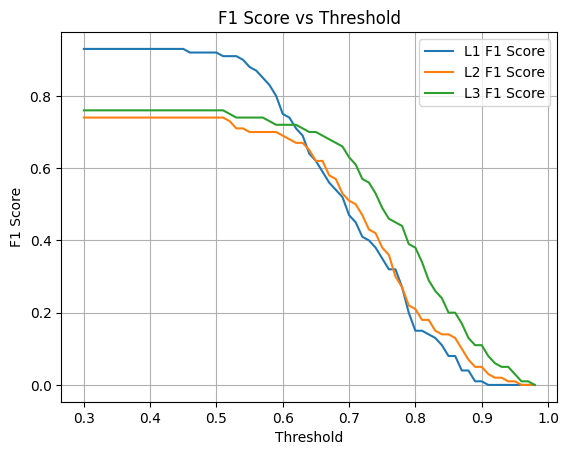

Best thresholds per level:
{'L1': (np.float64(0.3), 0.93), 'L2': (np.float64(0.3), 0.74), 'L3': (np.float64(0.3), 0.76)}


In [ ]:
plot_threshold_f1(level_scores)

print("Best thresholds per level:")
print(best_thresholds(level_scores))

In [ ]:
level_scores

{'L1': [(np.float64(0.3), 0.93),
  (np.float64(0.31), 0.93),
  (np.float64(0.32), 0.93),
  (np.float64(0.33), 0.93),
  (np.float64(0.34), 0.93),
  (np.float64(0.35000000000000003), 0.93),
  (np.float64(0.36000000000000004), 0.93),
  (np.float64(0.37000000000000005), 0.93),
  (np.float64(0.38000000000000006), 0.93),
  (np.float64(0.39000000000000007), 0.93),
  (np.float64(0.4000000000000001), 0.93),
  (np.float64(0.4100000000000001), 0.93),
  (np.float64(0.4200000000000001), 0.93),
  (np.float64(0.4300000000000001), 0.93),
  (np.float64(0.4400000000000001), 0.93),
  (np.float64(0.4500000000000001), 0.93),
  (np.float64(0.46000000000000013), 0.92),
  (np.float64(0.47000000000000014), 0.92),
  (np.float64(0.48000000000000015), 0.92),
  (np.float64(0.49000000000000016), 0.92),
  (np.float64(0.5000000000000002), 0.92),
  (np.float64(0.5100000000000002), 0.91),
  (np.float64(0.5200000000000002), 0.91),
  (np.float64(0.5300000000000002), 0.91),
  (np.float64(0.5400000000000003), 0.9),
  (np.f

Threshold as 0.5


# RE-RANKING